使用 LangGraph 创建一个基本聊天机器人。这个聊天机器人将直接回复用户的消息。

In [3]:
# 导入所需的类型提示模块
from typing import Annotated  # 用于类型注解
from typing_extensions import TypedDict  # 用于创建类型化字典

# 导入 LangGraph 相关模块
from langgraph.graph import StateGraph, START  # StateGraph用于构建图，START是图的起始节点标识符
from langgraph.graph.message import add_messages  # 用于定义消息列表的更新行为


# 定义状态类型
class State(TypedDict):
    """
    定义图的状态类型。使用TypedDict确保类型安全。
    State类型包含一个名为'messages'的键，其值是一个列表。
    """
    # messages 字段被注解为列表类型
    # Annotated[list, add_messages] 表示:
    # - list: messages的类型是列表
    # - add_messages: 当更新这个状态时，新消息会被追加到列表中，而不是覆盖原有内容
    messages: Annotated[list, add_messages]


# 创建状态图构建器实例
# StateGraph是一个用于构建有向图的类，它接受一个状态类型作为参数
# 这里我们传入上面定义的State类型，确保图中的状态数据符合预期的结构
graph_builder = StateGraph(State)
type(graph_builder)

langgraph.graph.state.StateGraph

我们的图现在可以处理两个关键任务

每个 节点 都可以接收当前 状态 作为输入，并输出状态的更新。
对 消息 的更新将追加到现有列表而不是覆盖它，这得益于与 Annotated 语法一起使用的预构建 add_messages 函数。

3. 添加一个节点

In [6]:
# 导入必要的模块
import os  # 用于环境变量操作
from langchain_openai import ChatOpenAI  # 导入 OpenAI 聊天模型
import dotenv

# 加载 .env 文件（如果存在）
dotenv.load_dotenv() 
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 
os.environ["OPENAI_BASE_URL"] = os.getenv("OPENAI_BASE_URL") 

# # 可选的基础 URL，如果存在则设置
# base_url = os.getenv("OPENAI_BASE_URL")
# os.environ['OPENAI_BASE_URL'] = base_url

# 初始化语言模型（只初始化一次）
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

聊天机器人节点详解

这段代码实现了聊天机器人的核心处理逻辑，主要包含两个关键部分：

1. **聊天机器人函数 (`chatbot`)**
   - **输入**: 接收 `state` 参数，这是一个包含对话历史的状态字典
   - **处理过程**:
     - 从状态中获取消息历史 (`state["messages"]`)
     - 使用语言模型 (`llm`) 处理这些消息
     - 生成适当的回复
   - **输出**: 返回包含新消息的字典，符合 `State` 类型的定义
   - **类型安全**: 使用类型注解确保函数签名符合预期

2. **节点注册 (`add_node`)**
   - **节点名称**: "chatbot" 作为唯一标识符
   - **处理函数**: 将 `chatbot` 函数注册为节点的处理器
   - **触发机制**: 当图执行到这个节点时，会自动调用注册的处理函数
   - **状态更新**: 处理函数的返回值会用于更新图的状态

3. **工作流程**
   ```
   接收状态(State) → 处理消息 → 生成回复 → 更新状态 → 继续处理
   ```

4. **状态管理**
   - 状态在整个图中流转
   - 每个节点可以访问和修改状态
   - 确保消息历史得到正确维护

这种设计使得聊天机器人能够：
- 维护对话的上下文
- 生成连贯的回复
- 保持状态的一致性
- 灵活处理各种输入

In [7]:
# 定义聊天机器人节点的处理函数
def chatbot(state: State):
    """
    处理聊天消息的核心函数。
    
    参数:
        state: State - 包含当前对话状态的字典，其中包含消息历史
        
    返回:
        dict: 包含更新后消息列表的字典
    """
    # llm.invoke() 接收消息历史并生成回复
    # state["messages"] 包含之前的对话历史
    # 返回的字典格式需要匹配 State 类型定义
    return {"messages": [llm.invoke(state["messages"])]}


# 将聊天机器人节点添加到图中
# add_node 方法用于在图中注册一个新的处理节点
# 参数说明：
# 1. "chatbot" - 节点的唯一标识符，用于在图中引用这个节点
# 2. chatbot - 当节点被触发时要调用的函数
graph_builder.add_node("chatbot", chatbot)

In [8]:
# 添加图的边，定义节点之间的连接关系
# START 是一个特殊的常量，表示图的起始点
# "chatbot" 是我们之前定义的节点的名称
# 这行代码创建了一个从 START 到 chatbot 节点的边，定义了数据流的方向
graph_builder.add_edge(START, "chatbot")

5、编译图
在运行图之前，我们需要对其进行编译。我们可以通过在图构建器上调用 compile() 来完成。这将创建一个 CompiledGraph，我们可以在我们的状态上调用它。

In [9]:
# 编译图结构
# 通过调用 compile() 方法，将图构建器创建的图结构转换为可执行的图实例
# 编译过程会验证图的完整性，确保所有连接都是有效的
graph = graph_builder.compile()

6. 可视化图（可选）
您可以使用 get_graph 方法和其中一个“绘图”方法（例如 draw_ascii 或 draw_png）来可视化图。这些 draw 方法都需要额外的依赖项。

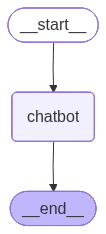

In [10]:
# 导入用于在Jupyter notebook中显示图像的工具
from IPython.display import Image, display

try:
    # 获取图的可视化表示
    # graph.get_graph() - 获取图的内部表示
    # draw_mermaid_png() - 使用Mermaid格式将图转换为PNG图像
    # Image() - 将PNG数据转换为可显示的图像对象
    # display() - 在notebook中显示图像
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # 如果缺少必要的依赖项（如graphviz），则跳过可视化
    # 这是一个可选功能，不影响图的实际功能
    # 要启用可视化，需要安装额外的依赖项
    pass

7. 运行聊天机器人

In [18]:
# 定义一个函数来处理用户输入并显示AI助手的响应
def stream_graph_updates(user_input: str):#功能：将用户输入转换为图可以处理的格式，并处理AI助手的响应
    """
    处理用户输入并实时显示AI助手的响应
    
    参数:
        user_input: str - 用户输入的文本消息
    """
    # 使用graph.stream()方法处理用户输入
    # {"messages": [{"role": "user", "content": user_input}]} 创建符合格式的用户消息
    # graph.stream() 会生成一系列事件，表示图的处理过程
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # event是一个字典，包含了图处理的结果
        # event.values()获取所有的处理结果
        for value in event.values():
            # value["messages"][-1]获取最新的消息
            # .content获取消息的具体内容
            # 打印助手的回复
            print("Assistant:", value["messages"][-1].content)


# 创建一个无限循环来持续接收用户输入
while True:
    try:
        # 获取用户输入
        user_input = input("User: ")
        
        # 检查是否是退出命令
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")  # 打印告别信息
            break  # 退出循环
            
        # 处理用户输入并获取响应
        stream_graph_updates(user_input)
        
    except:
        # 如果input()函数不可用（例如在某些环境中）
        # 使用默认的测试消息
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)  # 打印默认问题
        stream_graph_updates(user_input)  # 处理默认问题
        break  # 退出循环



Assistant: 你好，小智！很高兴认识你！有什么我可以帮助你的吗？
Assistant: 抱歉，我无法知道你的名字。如果你愿意，可以告诉我你的名字！
Goodbye!


TypeError: 'StateGraph' object is not subscriptable